In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from scipy import stats

# Data 102 Spring 2024 Lecture 8 Demo

## Bayesian Hierarchical Model for Kidney Cancer

## Data Exploration

We'll focus on the following columns in the kidney cancer dataset:
* `state`: the US state
* `Location`: the county and state as a string
* `fips`, which provides the [FIPS code]() for each county: this is a standard identifier that can often be used to join datasets with county-level information.
* `dc` and `dc.2`: the number of kidney cancer deaths between 1980-1984 and 1985-1989, respectively
* `pop` and `pop.2`: the population between 1980-1984 and 1985-1989, respectively

In [2]:
kc_full = pd.read_csv('kidney_cancer_1980.csv', skiprows=4)
# There are many other interesting columns, but we'll focus on these:
kc = kc_full.loc[:, ['state', 'Location', 'dc', 'dc.2', 'pop', 'pop.2']]
kc.head()

,state,Location,dc,dc.2,pop,pop.2
0,ALABAMA,"Autauga County, Alabama",2,1,61921,64915
1,ALABAMA,"Baldwin County, Alabama",7,15,170945,195253
2,ALABAMA,"Barbour County, Alabama",0,1,33316,33987
3,ALABAMA,"Bibb County, Alabama",0,1,30152,31175
4,ALABAMA,"Blount County, Alabama",3,5,88342,91547


<Axes: xlabel='rate_nopool', ylabel='Count'>

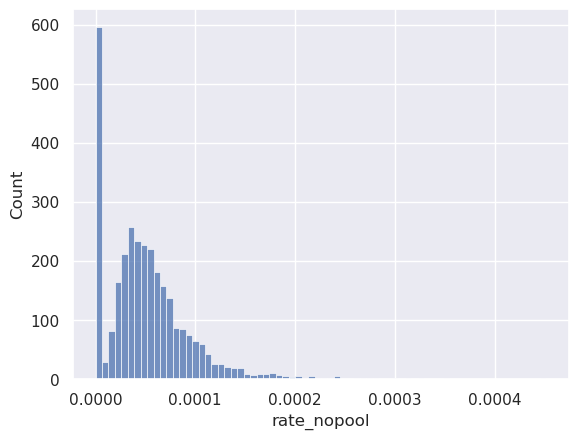

In [3]:
kc['rate_nopool'] = kc['dc'] / kc['pop']
sns.histplot(kc, x='rate_nopool')

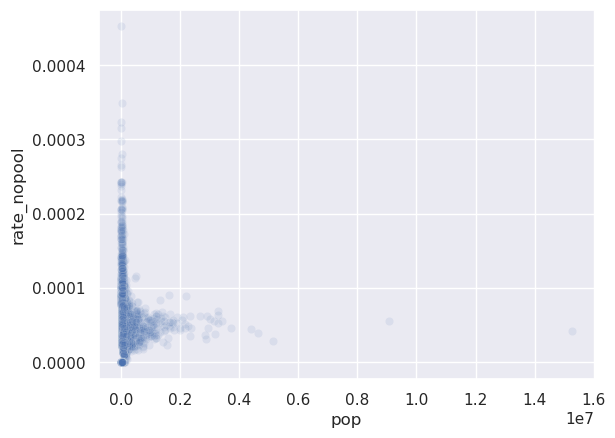

In [4]:
sns.scatterplot(kc, x='pop', y='rate_nopool', alpha=0.1);

In [5]:
# Complete pooling
total_pop = kc['pop'].sum()
total_dc = kc['dc'].sum()
overall_rate = total_dc / total_pop
overall_rate

4.856485743364176e-05

### Hierarchical model

Prior and likelihood:
$$
\begin{align*}
\theta_i &\sim \mathrm{Beta}(a, b), & i \in \{1, 2, \ldots\} \\
y_i | \theta_i &\sim \mathrm{Binomial}(\theta_i, n_i), & i \in \{1, 2, \ldots\}
\end{align*}
$$

Posterior
$$
\theta_i | y_i \sim \mathrm{Beta}(a + y_i, b + n_i - y_i)
$$



#### Empirical Bayes

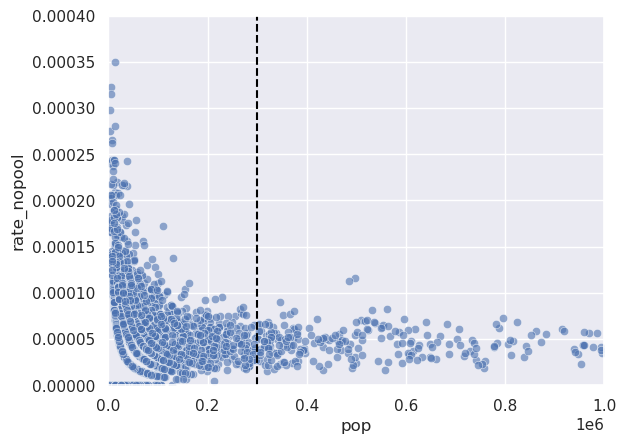

In [6]:
sns.scatterplot(kc, x='pop', y='rate_nopool', alpha=0.6);
plt.vlines(3e5, 0, 0.0004, color='black', ls='--')
plt.axis([0, 1e6, 0, 0.0004]);

<Axes: xlabel='rate_nopool', ylabel='Count'>

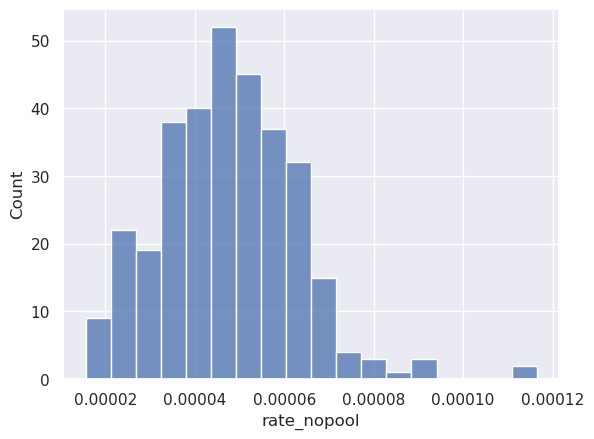

In [7]:

kc_large_counties = kc[kc['pop'] > 300000]
sns.histplot(kc_large_counties, x='rate_nopool')

In [8]:
# Maximum likelihood estimation using scipy: find parameters of a Beta distribution that make the histogram above
# as likely as possible

# The last two arguments tell scipy that it shouldn't try to shift or scale our Beta distribution
a_hat, b_hat, loc_, scale_ = stats.beta.fit(kc_large_counties['rate_nopool'], floc=0, fscale=1)
print(a_hat, b_hat)

9.270228250937594 195581.04128772262


In [9]:
a_guess, b_guess = 5, 19995  # educated guess
a_eb, b_eb = a_hat, b_hat  # empirical bayes

def compute_posterior(kc, prior_a, prior_b):
    posterior_a = prior_a + kc['dc']
    posterior_b = prior_b + (kc['pop'] - kc['dc'])
    return posterior_a, posterior_b
kc['posterior_a_guess'], kc['posterior_b_guess'] = compute_posterior(kc, a_guess, b_guess)
kc['posterior_a_eb'], kc['posterior_b_eb'] = compute_posterior(kc, a_eb, b_eb)

# For a Beta(a, b) distribution, the mean is a / (a + b)
kc['lmse_guess'] = kc['posterior_a_guess'] / (kc['posterior_a_guess'] + kc['posterior_b_guess'])
kc['lmse_eb'] = kc['posterior_a_eb'] / (kc['posterior_a_eb'] + kc['posterior_b_eb'])


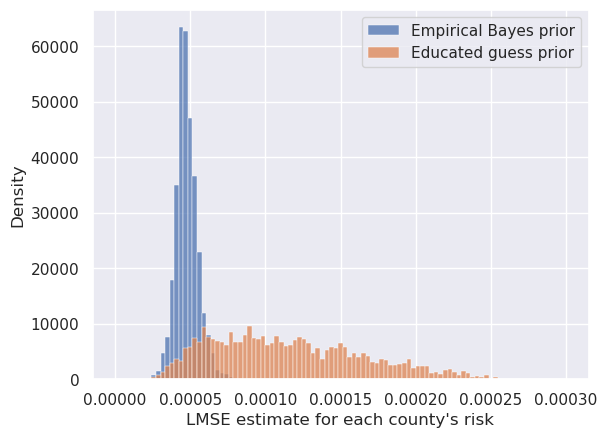

In [10]:
bins = np.linspace(0, 0.0003, 100)
sns.histplot(kc, x='lmse_eb', stat='density', label='Empirical Bayes prior', bins=bins)
sns.histplot(kc, x='lmse_guess',  stat='density', label='Educated guess prior', bins=np.linspace(0, 0.0003, 100))
plt.xlabel("LMSE estimate for each county's risk")
plt.legend()

# Sampling

## Simple example: sampling for a known distribution

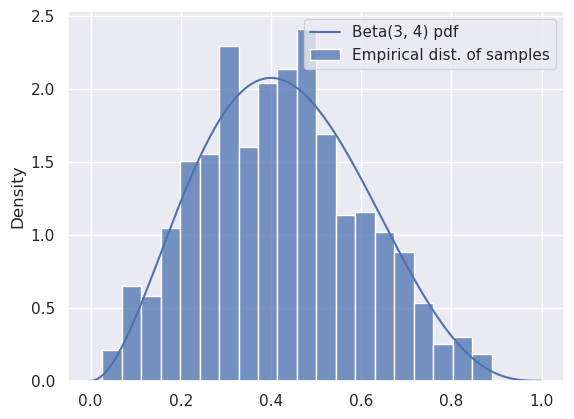

In [28]:

from scipy import stats

my_distribution = stats.beta(3, 4)

# Compute the exact PDF:
t = np.linspace(0, 1, 500)
pdf = my_distribution.pdf(t)

# Draw 1000 samples, and look at the empirical distribution of those samples:
samples = my_distribution.rvs(1000)
f, ax = plt.subplots(1, 1)

sns.histplot(x=samples, stat='density', bins=20, label='Empirical dist. of samples')
ax.plot(t, pdf, label='Beta(3, 4) pdf')
ax.legend()

## Sampling with PyMC

In [11]:
import pymc as pm
import arviz as az


In [12]:
reviews_a = np.array([1, 1, 1])
reviews_b = np.append(np.ones(19), np.zeros(1))

In [13]:


# Parameters of the prior
a = 1
b = 5

with pm.Model() as model:
    # Define a Beta-distributed random variable called theta
    theta = pm.Beta('theta', alpha=a, beta=b)
    
    # Defines a Bernoulli RV called x. Since x is observed, we
    # pass in the observed= argument to provide our data
    x = pm.Bernoulli('x', p=theta, observed=reviews_b)
    
    # This line asks PyMC3 to approximate the posterior.
    # Don't worry too much about how it works for now.
    trace = pm.sample(2000, chains=2, tune=200, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 200 tune and 2_000 draw iterations (400 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    theta    (chain, draw) float64 0.6764 0.8071 0.7508 ... 0.79 0.8467 0.7367
Attributes:
    created_at:                 2024-02-08T19:27:07.969831
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.8.1
    sampling_time:              1.1581051349639893
    tuning_steps:               200

In [16]:
samples = trace.posterior['theta'].values.flatten()

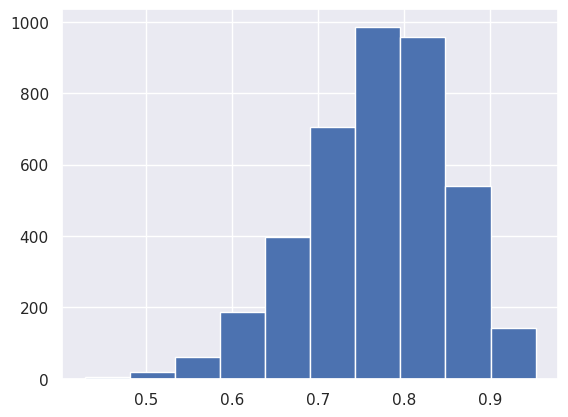

In [17]:
plt.hist(samples);

## Hierarchical Model

In [18]:


# Parameters of the prior
a = 9
b = 195581
num_counties = kc.shape[0]

with pm.Model() as model:
    theta = pm.Beta('theta', alpha=a, beta=b, shape=num_counties)
    y = pm.Binomial('y', p=theta, n=kc['pop'], observed=kc['dc'])
    
    # This line asks PyMC3 to approximate the posterior.
    # Don't worry too much about how it works for now.
    trace_hier = pm.sample(2000, chains=2, tune=200, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 200 tune and 2_000 draw iterations (400 + 4_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
thetas = trace_hier.posterior['theta'].values
thetas.shape

(2, 2000, 3110)

In [20]:
thetas = thetas.reshape(-1, 3110)
thetas

array([[3.23545737e-05, 4.76117463e-05, 3.70218450e-05, ...,
        7.83685045e-05, 4.97256787e-05, 4.52402693e-05],
       [5.39253350e-05, 3.94106199e-05, 2.49733257e-05, ...,
        1.81323057e-05, 3.83417295e-05, 3.67485652e-05],
       [3.32362254e-05, 4.34029617e-05, 5.55548398e-05, ...,
        7.34870809e-05, 3.16599294e-05, 3.63080033e-05],
       ...,
       [5.89440788e-05, 4.58532205e-05, 1.83849245e-05, ...,
        5.66281772e-05, 3.85266272e-05, 5.02933849e-05],
       [2.38566998e-05, 5.19291624e-05, 7.77227756e-05, ...,
        3.72484930e-05, 3.86928683e-05, 4.63434637e-05],
       [5.64777322e-05, 4.29496622e-05, 1.78803532e-05, ...,
        5.82720409e-05, 7.43950690e-05, 5.00873847e-05]])

In [22]:


# Parameters of the prior
#a = 1
#b = 5
num_counties = kc.shape[0]

with pm.Model() as model:
    a_rv = pm.Uniform('a', lower=1, upper=500)
    b_rv = pm.Uniform('b', lower=1, upper=3000000)
    
    theta = pm.Beta('theta', alpha=a_rv, beta=b_rv, shape=num_counties)
    y = pm.Binomial('y', p=theta, n=kc['pop'], observed=kc['dc'])
    
    # This line asks PyMC3 to approximate the posterior.
    # Don't worry too much about how it works for now.
    trace_full_hier = pm.sample(1000, chains=2, tune=100, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, theta]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 192 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [23]:
a_samples = trace_full_hier.posterior['a'].values.flatten()
b_samples = trace_full_hier.posterior['b'].values.flatten()

<Axes: >

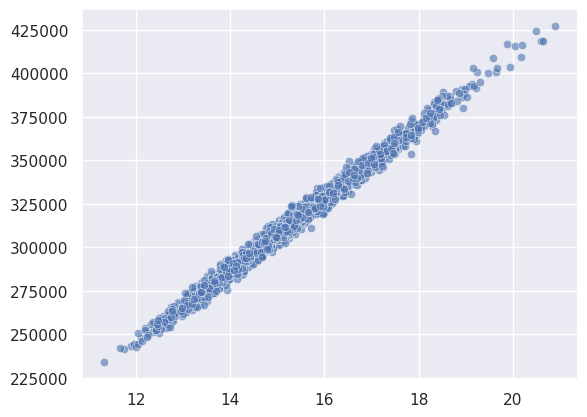

In [24]:
sns.scatterplot(x=a_samples, y=b_samples, alpha=0.6)

In [25]:
a_samples / (a_samples + b_samples)

array([4.84916234e-05, 4.86819012e-05, 4.90934108e-05, ...,
       4.93111048e-05, 4.95412816e-05, 4.88145175e-05])

<Axes: >

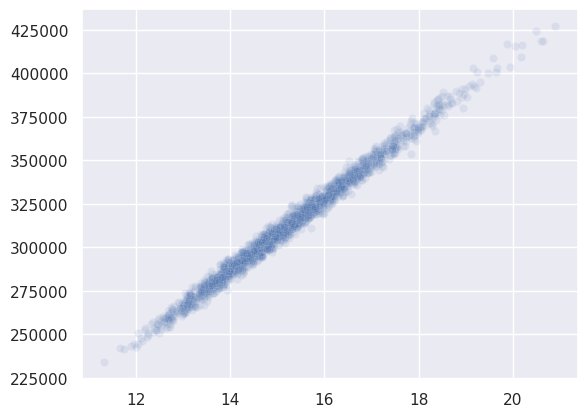

In [26]:
sns.scatterplot(x=a_samples, y=b_samples, alpha=0.1)

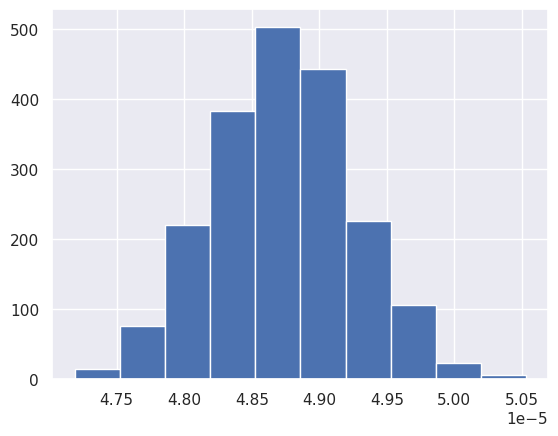

In [27]:
overall_mean_est = a_samples / (a_samples + b_samples)
plt.hist(overall_mean_est);